# Импорты

In [45]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification, make_circles
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Подгрузка данных

Нам достался датасет, сразу разбитый на train и test в отдельных файлах, поэтому сначала мы их объединим в один датафрэйм

In [46]:
datatrain = pd.read_table("datatraining.txt", sep = ',')
datatest = pd.read_table("datatest.txt", sep = ',')
datatest2 = pd.read_table("datatest2.txt", sep = ',')

In [47]:
df = pd.merge(datatrain, datatest, how = "outer")

In [48]:
df = pd.merge(df, datatest2, how = "outer")

In [49]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


Для обработки был выбран датасэт, в котором содержится набор ежеминутных наблюдений за климатическими показателям в помещении:
- температура
- влажность
- освещённость
- уровень углекислого газа
- удельная влажность

В качестве целевой переменной выступает бинарный признак - занято ли помещение людьми.

Также в датасете присутствует таймстэмп времени наблюдения - уникальный для каждого элемента. 
Можно было бы его использовать как дополнительный признак (выделить день недели, например), но мы его просто исключим из датасета

In [50]:
df.drop(['date'], axis=1, inplace=True)

# Первичный анализ

In [51]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


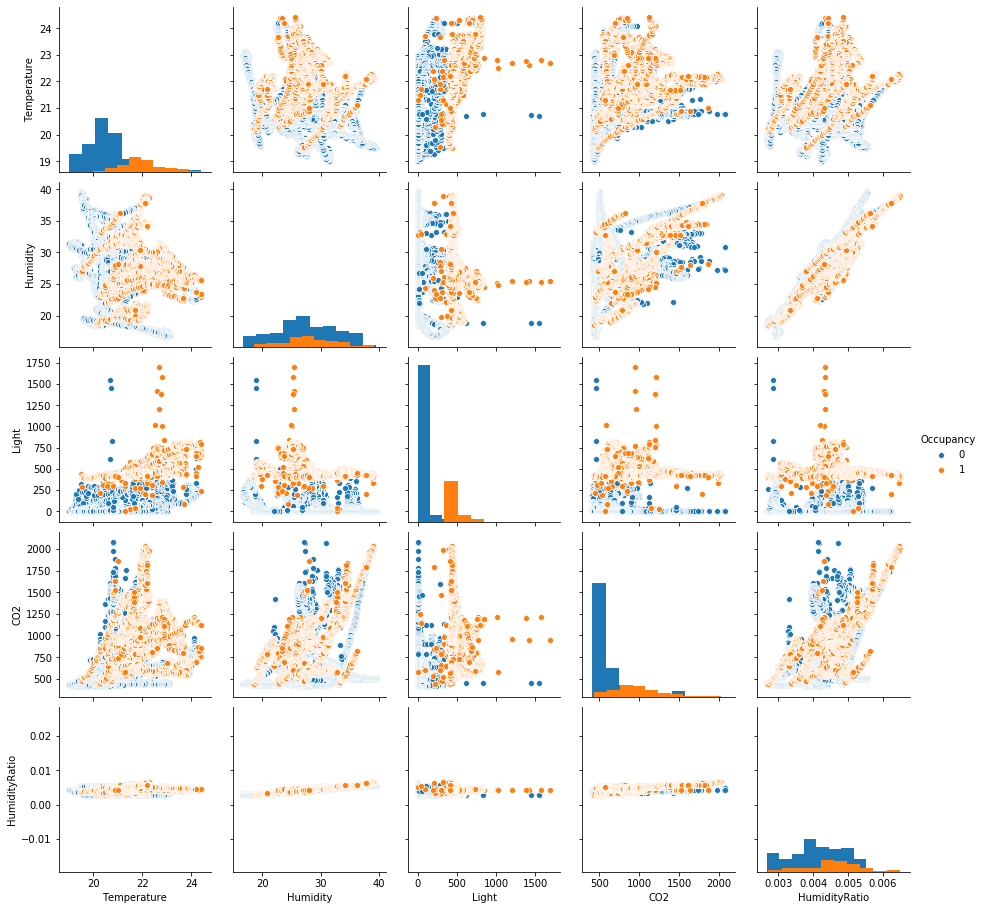

In [52]:
sns.pairplot(df, hue = "Occupancy", diag_kind = "hist")

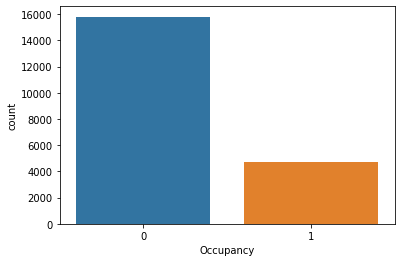

In [53]:
sns.countplot(x='Occupancy',data=df)

In [54]:
(df['Occupancy'].value_counts()/len(df)).round(2)

0    0.77
1    0.23
Name: Occupancy, dtype: float64

Наблюдается приличный дисбаланс классов - 1 к 3. Пожалуй, используем uder-sampling для выравнивания доли классов

# Предобработка

In [55]:
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(random_state=0)
X, y = RUS.fit_resample(df.drop(['Occupancy'], axis = 1), df['Occupancy'])

Under-sampling отделил целевой признак от предикатов, соединим их обратно для разбиения на train-test и шкалирования

In [56]:
df_balanced = pd.concat([X, y], axis = 1)

In [66]:
df_balanced.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,20.60,34.590,24.0,514.0,0.005197,0
1,19.60,39.245,0.0,503.0,0.005545,0
2,21.20,25.100,0.0,446.0,0.003905,0
3,19.29,27.700,0.0,432.0,0.003829,0
4,21.00,26.390,0.0,565.0,0.004056,0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.drop(['Occupancy'], axis=1),
    df_balanced['Occupancy'],
    test_size=0.3,
    stratify=df_balanced['Occupancy'],
    random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Сначала посмотрим на результаты логистической регресси, чтобы сравнить их с SVM

In [61]:
model_LogR = LogisticRegression()
model_LogR.fit(X_train_scaled, y_train)
pred_LR = model_LogR.predict(X_test_scaled)

In [62]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n" +\
                 "ROC-AUC: \t {:.3f}"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    
    quality_list = [acc.round(5), precision.round(5), recall.round(5), f1, rocauc.round(5)]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            accuracy_score(prediction, actual),
            precision_score(prediction, actual),
            recall_score(prediction, actual),
            f1_score(prediction, actual),
            roc_auc_score(prediction, actual)
        ))
        print("======================\n")
    
    return quality_list


In [63]:
quality_LR = quality_report(pred_LR, y_test)
df_quality = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"])
df_quality.loc["LR", :] = quality_LR
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.997
Recall: 	 0.984
f1_score: 	 0.991
ROC-AUC: 	 0.991



,Accuracy,Precision,Recall,F1,ROC-AUC
LR,0.99053,0.99719,0.98407,0.990589,0.99061


Уже весьма неплохие результаты, но посмотрим, что на это скажет SVM

In [64]:
model_svc = svm.SVC()
model_svc.fit(X_train_scaled, y_train)
pred_SVC = model_svc.predict(X_test_scaled)

In [65]:
quality_SVC = quality_report(pred_SVC, y_test)
df_quality.loc["SVC", :] = quality_SVC
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.997
Recall: 	 0.985
f1_score: 	 0.991
ROC-AUC: 	 0.991



,Accuracy,Precision,Recall,F1,ROC-AUC
LR,0.99053,0.99719,0.98407,0.990589,0.99061
SVC,0.99123,0.99719,0.98544,0.99128,0.9913


SVM ещё немного улучшил метрики модели. Для интереса посмотрим, как сработает модель на несбалансированных по классам данных

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Occupancy'], axis=1),
    df['Occupancy'],
    test_size=0.3,
    stratify=df['Occupancy'],
    random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
model_LogR = LogisticRegression()
model_LogR.fit(X_train_scaled, y_train)
pred_LR = model_LogR.predict(X_test_scaled)

In [69]:
quality_LR = quality_report(pred_LR, y_test)
df_quality.loc["LR_disb", :] = quality_LR
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.988
Precision: 	 0.995
Recall: 	 0.954
f1_score: 	 0.974
ROC-AUC: 	 0.976



,Accuracy,Precision,Recall,F1,ROC-AUC
LR,0.99053,0.99719,0.98407,0.990589,0.99061
SVC,0.99123,0.99719,0.98544,0.99128,0.9913
LR_disb,0.98784,0.99509,0.95424,0.974236,0.97637


In [70]:
model_svc = svm.SVC()
model_svc.fit(X_train_scaled, y_train)
pred_SVC = model_svc.predict(X_test_scaled)

In [71]:
quality_SVC = quality_report(pred_SVC, y_test)
df_quality.loc["SVC_disb", :] = quality_SVC
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.988
Precision: 	 0.996
Recall: 	 0.954
f1_score: 	 0.975
ROC-AUC: 	 0.976



,Accuracy,Precision,Recall,F1,ROC-AUC
LR,0.99053,0.99719,0.98407,0.990589,0.99061
SVC,0.99123,0.99719,0.98544,0.99128,0.9913
LR_disb,0.98784,0.99509,0.95424,0.974236,0.97637
SVC_disb,0.988,0.99579,0.95427,0.974588,0.97649


Видно, что не зря балансировали классы - метрики на первоначальном датафрейме чуть похуже